
 Total number of symbols (financial instruments) is 20

Training and Evaluating for symbol 1 ...

Feature series shape: (142632, 79)

Responder series shape: (142632, 8)

Target series shape: (142632,)

Number of clean features: 43

Regression data shapes:
X shape: (142632, 51) (samples, features+responders)
y shape: (142632,)

Total parameter combinations: 32

Total fits with 5-fold CV: 160
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best parameters found:
{'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}

Best cross-validation R²: 0.6863

Model Performance:
Train MSE: 0.0985
Test MSE: 0.1007
Train R²: 0.7579
Test R²: 0.7491


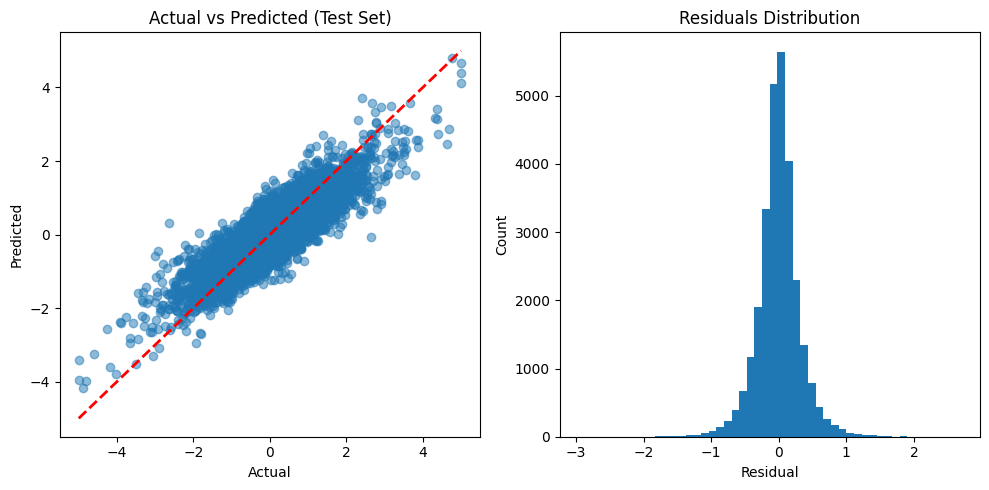


Training and Evaluating for symbol 7 ...

Feature series shape: (140085, 79)

Responder series shape: (140085, 8)

Target series shape: (140085,)

Number of clean features: 38

Regression data shapes:
X shape: (140085, 46) (samples, features+responders)
y shape: (140085,)

Total parameter combinations: 32

Total fits with 5-fold CV: 160
Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

def create_timeseries_for_symbol(df, symbol_id):
    """
    Create feature and responder time series for a given symbol
    
    Args:
        df: Input dataframe
        symbol_id: Symbol to process
    
    Returns:
        tuple: (feature_series, responder_series)
    """
    # Sort by date_id and time_id, then filter for our symbol
    df_sorted = df.sort_values(['date_id', 'time_id'])
    symbol_data = df_sorted[df_sorted['symbol_id'] == symbol_id].copy()
    
    # Get column names
    feature_cols = [col for col in df.columns if col.startswith('feature_')]
    responder_cols = [col for col in df.columns if col.startswith('responder_') and col != 'responder_6']

    target_col = 'responder_6'
    
    # Get first date and its last time for responders
    first_date = symbol_data['date_id'].min()
    first_date_last_time = symbol_data[symbol_data['date_id'] == first_date]['time_id'].max()
    first_date_last_responders = symbol_data[
        (symbol_data['date_id'] == first_date) & 
        (symbol_data['time_id'] == first_date_last_time)
    ][responder_cols]
    
    # Get all data after first date (for features)
    feature_series = symbol_data[symbol_data['date_id'] > first_date][feature_cols].copy()

    # Get all data after first date (for target)
    target_series = symbol_data[symbol_data['date_id'] > first_date][target_col].copy()

    # Get all data after first date except the last row (for responders)
    responder_data = symbol_data[symbol_data['date_id'] > first_date][responder_cols].iloc[:-1]
    
    # Add first date's last responders at the start
    responder_series = pd.concat([first_date_last_responders, responder_data])
    
    # Print verification
    print(f"\nFeature series shape: {feature_series.shape}")

    print(f"\nResponder series shape: {responder_series.shape}")

    print(f"\nTarget series shape: {target_series.shape}")

    return feature_series, responder_series, target_series

def prepare_regression_data(features, responders, target):
    """
    Prepare X and y for regression by:
    1. Removing features with NaN
    2. Combining clean features with responders
    3. Aligning with target
    """
    # Get clean features (no NaN)
    clean_features = features.loc[:, ~features.isna().any()].reset_index(drop=True)
    responders = responders.reset_index(drop=True)
    target = target.reset_index(drop=True)
    
    print(f"\nNumber of clean features: {len(clean_features.columns)}")
    
    # Make sure all have same length
    min_len = min(len(clean_features), len(responders), len(target))
    clean_features = clean_features.iloc[:min_len]
    responders = responders.iloc[:min_len]
    target = target.iloc[:min_len]
    
    # Combine clean features and responders for X
    X = pd.concat([clean_features, responders], axis=1)
    y = target
    
    print("\nRegression data shapes:")
    print(f"X shape: {X.shape} (samples, features+responders)")
    print(f"y shape: {y.shape}")
        
    return X, y

def tune_xgboost(X, y):
    """
    Tune XGBoost hyperparameters using a focused parameter grid
    """
    # Define smaller parameter grid
    param_grid = {
        'n_estimators': [100, 200],          # removed 300
        'max_depth': [4, 6],                 # just 2 values
        'learning_rate': [0.01, 0.1],        # removed middle value
        'subsample': [0.8, 1.0],             # removed 0.9
        'min_child_weight': [1, 3]           # removed 5
    }
    
    # Calculate total combinations
    total_combinations = 2 * 2 * 2 * 2 * 2  # = 32 combinations
    print(f"\nTotal parameter combinations: {total_combinations}")
    print(f"\nTotal fits with 5-fold CV: {total_combinations * 5}")
    
    # Initialize XGBoost model
    xgb = XGBRegressor(random_state=42)
    
    # Set up GridSearchCV
    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring='r2',
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    
    # Fit GridSearchCV
    grid_search.fit(X, y)
    
    # Print results
    print("\nBest parameters found:")
    print(grid_search.best_params_)
    print(f"\nBest cross-validation R²: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_

def evaluate_model(model, X_train, X_test, y_train, y_test):
    """
    Evaluate its performance
    """
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    print("\nModel Performance:")
    print(f"Train MSE: {train_mse:.4f}")
    print(f"Test MSE: {test_mse:.4f}")
    print(f"Train R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    
    # Plot actual vs predicted for test set
    plt.figure(figsize=(10, 5))
    
    # First subplot: Actual vs Predicted scatter
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted (Test Set)')
    
    # Second subplot: Residuals
    plt.subplot(1, 2, 2)
    residuals = y_test - y_test_pred
    plt.hist(residuals, bins=50)
    plt.xlabel('Residual')
    plt.ylabel('Count')
    plt.title('Residuals Distribution')
    
    plt.tight_layout()
    plt.show()
    
    return model

if __name__ == "__main__":
    # Load and prepare data (with all features and responders)
    df = pd.read_parquet("train.parquet/partition_id=0/part-0.parquet")
    list_of_symbols = df['symbol_id'].unique()

    print(f"\n Total number of symbols (financial instruments) is {len(list_of_symbols)}")
    symbol_id = list_of_symbols[0]

    for symbol_id in list_of_symbols:
        print(f"\nTraining and Evaluating for symbol {symbol_id} ...")
        features, responders, target = create_timeseries_for_symbol(df, symbol_id)
        X, y = prepare_regression_data(features, responders, target)
        
        # Tune model
        best_model = tune_xgboost(X, y)
        
        # Evaluate best model
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        evaluate_model(best_model, X_train, X_test, y_train, y_test)